In [19]:
filename = 'hdf5/superlong_1.h5' #Format: 'hdf5/FileName.h5'
                                 #'hdf5' is the name of the folder that contains the hdf5 file named FileName, .h5 is
                                 #format of the file (like .txt or .csv)
a = 5

In [20]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

import gm2
import trfp
import plotting_functions as plt2
import LegendreAnalysisHelper as helper
#import AnalysisHelper2 as helper
import helper_function_candidates as helper_old
import allantools
from IPython.display import clear_output
from AnalysisHelper import root_to_pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def Averages(moment_df, station0, binsize):
    #Not sure how to account for stations with 4 and 6 probes, thus only up to m4 is included
    #station0 should be an int
    nEvents = len(moment_df["st" + str(station0) + ",m1"].to_numpy()[(binsize-1):])
    avgsm1 = np.zeros((37, nEvents))
    avgsm2 = np.zeros((37, nEvents))
    avgsm3 = np.zeros((37, nEvents))
    avgsm4 = np.zeros((37, nEvents))
    avgsm5 = np.zeros((37, nEvents))
    
    avgms = np.zeros((5, 37, nEvents))
    
    avgsm1[0] = moment_df["st" + str(station0) + ",m1"].to_numpy()[(binsize-1):]
    avgsm2[0] = moment_df["st" + str(station0) + ",m2"].to_numpy()[(binsize-1):]
    avgsm3[0] = moment_df["st" + str(station0) + ",m3"].to_numpy()[(binsize-1):]
    avgsm4[0] = moment_df["st" + str(station0) + ",m4"].to_numpy()[(binsize-1):]
    avgsm5[0] = moment_df["st" + str(station0) + ",m5"].to_numpy()[(binsize-1):]
    
    for i in range(1,36):
        avgsm1[i] = (moment_df["st" + str((station0 + i)%72) + ",m1"].to_numpy()[(binsize-1):]\
        + moment_df["st" + str((station0 - i)%72) + ",m1"].to_numpy()[(binsize-1):])/2
        
        avgsm2[i] = (moment_df["st" + str((station0 + i)%72) + ",m2"].to_numpy()[(binsize-1):]\
        + moment_df["st" + str((station0 - i)%72) + ",m1"].to_numpy()[(binsize-1):])/2
        
        avgsm3[i] = (moment_df["st" + str((station0 + i)%72) + ",m3"].to_numpy()[(binsize-1):]\
        + moment_df["st" + str((station0 - i)%72) + ",m1"].to_numpy()[(binsize-1):])/2
        
        avgsm4[i] = (moment_df["st" + str((station0 + i)%72) + ",m4"].to_numpy()[(binsize-1):]\
        + moment_df["st" + str((station0 - i)%72) + ",m1"].to_numpy()[(binsize-1):])/2
        
        avgsm5[i] = (moment_df["st" + str((station0 + i)%72) + ",m5"].to_numpy()[(binsize-1):]\
        + moment_df["st" + str((station0 - i)%72) + ",m1"].to_numpy()[(binsize-1):])/2
        
        
    avgsm1[36] = moment_df["st" + str((station0 + 36)%72) + ",m1"].to_numpy()[(binsize-1):]
    
    avgsm2[36] = moment_df["st" + str((station0 + 36)%72) + ",m2"].to_numpy()[(binsize-1):]
    
    avgsm3[36] = moment_df["st" + str((station0 + 36)%72) + ",m3"].to_numpy()[(binsize-1):]
    
    avgsm4[36] = moment_df["st" + str((station0 + 36)%72) + ",m4"].to_numpy()[(binsize-1):]
    
    avgsm5[36] = moment_df["st" + str((station0 + 36)%72) + ",m5"].to_numpy()[(binsize-1):]
    
    return avgsm1,avgsm2,avgsm3,avgsm4,avgsm5

def SqRes(B, t, dt):
    N = int(len(B)/dt)
    s = 0
    for i in range(N):
        p = np.polyfit(t[i:i+dt], B[i:i+dt], 1)
        s+= np.sum(abs(B[i:i+dt] - np.polyval(p, t[i:i+dt]))**2)
    return s/len(t)

def FFTNoise(B, dt = 8):
    N = int(len(B)/dt)
    s = 0
    for i in range(N):
        C = np.fft.rfft(B[i:i+dt+1])
        s+= sum(abs(C[1:5]))
    return s

def DiffNoise(B):
    s = 0
    for i in range(len(B)-1):
        s+= abs(B[i] - B[i+1])
    return s/len(B)

def ProbeToStationRearrange(Meas, nbars):
    ringData = np.zeros(72*(nbars))
    
    for i in range(len(trfp.STATION_PROBE_ID)):
        for j in range(len(trfp.STATION_PROBE_ID[i])):
            ringData[i*(nbars) + j] = Meas[trfp.STATION_PROBE_ID[i][j]]
    return ringData


def RingPlot(ring, nbars):
    N = 72*(nbars)
    bottom = 4
    max_height = 10-bottom
    
    theta = np.linspace(0.0 - (10*np.pi/180), 2*np.pi- (10*np.pi/180), N, endpoint= False)
    radii = max_height*ring/np.amax(ring)
    width = (2*np.pi)/N
    
    fig, ax = plt.subplots(1,1, subplot_kw=dict(projection="polar"))
    k = 7
    fig.set_figheight(2*k)
    fig.set_figwidth(3*k)
    bars = ax.bar(theta, radii, width=width, bottom=bottom)

    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.jet(r / 10.))
        bar.set_alpha(0.8)
    ax.set_thetagrids(np.linspace(0, 360, 73))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    plt.show()

In [22]:
#trfp.STATION_PROBE_ID

In [23]:
interp_df = pd.read_hdf(filename)

634.3977366436042
828.1658276728174
178.88808535903544
638.1781565484946


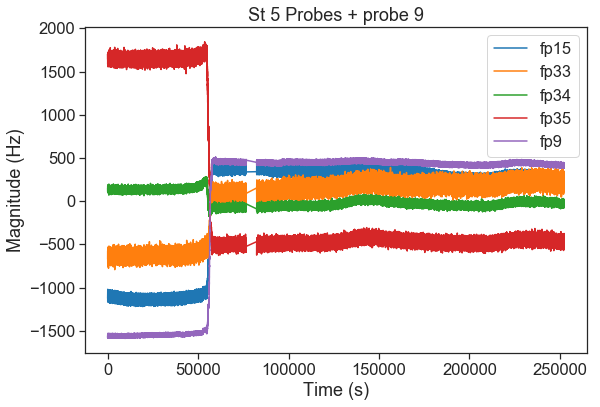

In [24]:
#Look at station probe measurements
a=5
Station5 = trfp.STATION_PROBE_ID[a]
k = 3
plt.figure(figsize = (3*k,2*k))
for i in Station5:
    if i == 16 or i == 17:
        continue
    plt.plot(interp_df['fp'+ str(i)].to_numpy() \
             - np.average(interp_df['fp'+ str(i)].to_numpy()), label = "fp" + str(i))
    print(SqRes(interp_df['fp'+ str(i)].to_numpy(), np.arange(len(interp_df['fp'+ str(i)].to_numpy())), 10))

plt.plot(interp_df['fp'+ str(9)].to_numpy() \
         - np.average(interp_df['fp'+ str(9)].to_numpy()), label = "fp" + str(9))
plt.legend()
plt.title("St " + str(a) + " Probes + probe 9")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude (Hz)")
plt.show()
a = 22

In [25]:
diffNoise = np.zeros(378)
k = 0
for i in range(len(trfp.STATION_PROBE_ID)):
    for j in range(len(trfp.STATION_PROBE_ID[i])):
        diffNoise[k] = DiffNoise(interp_df['fp'+ str(trfp.STATION_PROBE_ID[i][j])].to_numpy())
        k+=1
        if k%10 == 1:
            print(str(k) + '/378')

1/378
11/378
21/378
31/378
41/378
51/378
61/378
71/378
81/378
91/378
101/378
111/378
121/378
131/378
141/378
151/378
161/378
171/378
181/378
191/378
201/378
211/378
221/378
231/378
241/378
251/378
261/378
271/378
281/378
291/378
301/378
311/378
321/378
331/378
341/378
351/378
361/378
371/378


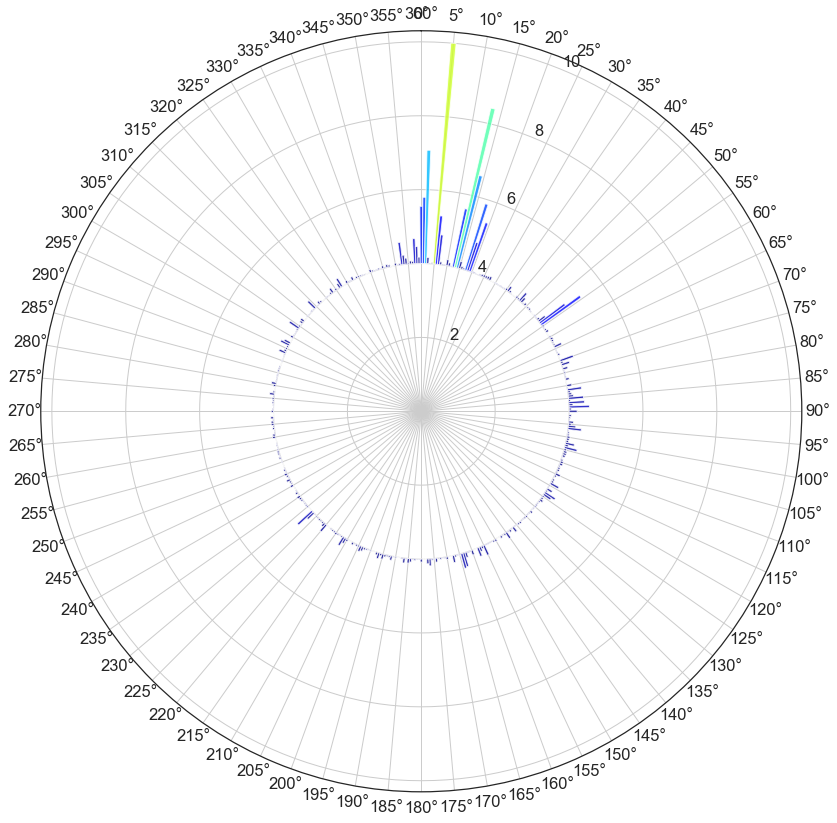

In [26]:
ringNoise = ProbeToStationRearrange(diffNoise, nbars= 6)
RingPlot(ringNoise, 6)

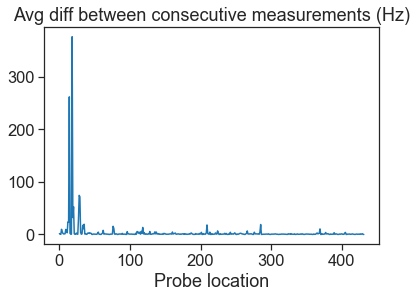

In [9]:
probes = np.arange(378)
plt.plot(ringNoise)
plt.title("Avg diff between consecutive measurements (Hz)")
plt.xlabel("Probe location")
plt.show()

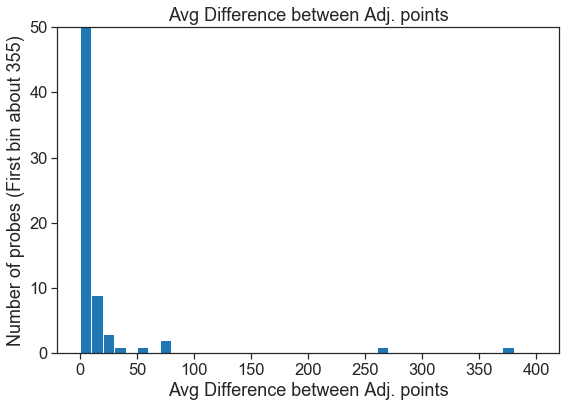

In [13]:
fig, axs = plt.subplots(1,1)
k = 3
fig.set_figheight(2*k)
fig.set_figwidth(3*k)

axs.hist(diffNoise, bins = np.linspace(0, 400, 41))
axs.set_xlabel("Avg Difference between Adj. points")
axs.set_ylabel("Number of probes (First bin about 355)")
#axs.set_xscale('')
axs.set_ylim(0,50)
axs.set_title("Avg Difference between Adj. points")
plt.show()

In [12]:
#Plot what each probe measures
#for i in range(17):
#    plt.plot(interp_df[])

In [18]:
x = np.linspace(0,10,11)
y = np.array([0,-1,-2,-3,-4,-3,-2,-3,-2, -1, -2])

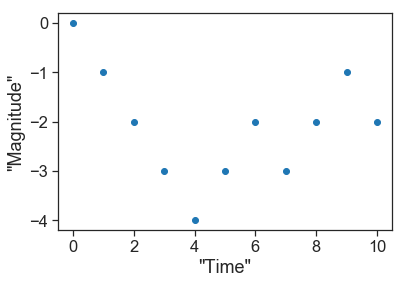

In [23]:
plt.plot(x,y,'o')
plt.xlabel('\"Time\"')
plt.ylabel('\"Magnitude\"')
plt.show()